In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

%matplotlib inline

from pydrake.all import (SignalLogger, CompliantMaterial, ConstantVectorSource, DirectCollocation, DiagramBuilder, FloatingBaseType,
                         PiecewisePolynomial, RigidBodyTree, RigidBodyPlant,
                         SolutionResult, AddModelInstancesFromSdfString,
                         MathematicalProgram, Simulator, BasicVector, AddFlatTerrainToWorld)
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

In [7]:
# set the initial state

x = -1.0
z = 1.5

x_dot = 1.0
z_dot = 1.0

# state of the flywheel
phi = 0.0
phi_dot = 0.0

torque = -5.0



Num states: 14
Spawning PlanarRigidBodyVisualizer for tree with 1 actuators


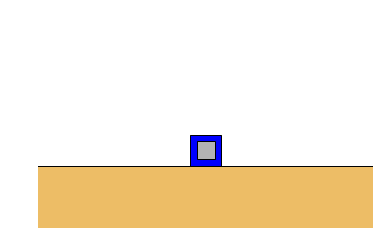

In [8]:
timestep = 0.0
builder = DiagramBuilder()
tree = RigidBodyTree(FindResource("cubli/cubli.urdf"),
                     FloatingBaseType.kFixed)
plant = RigidBodyPlant(tree, timestep)
nx = tree.get_num_positions() + tree.get_num_velocities()
print("Num states: {}".format(nx))

allmaterials = CompliantMaterial()
allmaterials.set_youngs_modulus(1E9) # default 1E9
allmaterials.set_dissipation(1.0) # default 0.32
allmaterials.set_friction(1.0) # default 0.9.
plant.set_default_compliant_material(allmaterials)

plant_context = plant.CreateDefaultContext()

robot = builder.AddSystem(plant)

torque_system = builder.AddSystem(ConstantVectorSource(
    np.ones((tree.get_num_actuators(), 1))*torque))
builder.Connect(torque_system.get_output_port(0),
                robot.get_input_port(0))

# what do xlim and ylim mean, what about -5 for the ground element
vis = builder.AddSystem(PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-1, 2.5]))
builder.Connect(robot.get_output_port(0),
                vis.get_input_port(0))

# And also log
signalLogRate = 60
signalLogger = builder.AddSystem(SignalLogger(nx))
signalLogger._DeclarePeriodicPublish(1. / signalLogRate, 0.0)
builder.Connect(robot.get_output_port(0),
                signalLogger.get_input_port(0))

diagram = builder.Build()

simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
simulator.set_publish_every_time_step(False)

In [9]:
context = simulator.get_mutable_context()
state = context.get_mutable_state().get_mutable_continuous_state().get_mutable_vector()
state.SetFromVector((x,0.,z,0.,0.,0.,phi,x_dot,0.,z_dot,0.,0.,0.,phi_dot))
simulator.StepTo(2)

In [10]:
ani = vis.animate(signalLogger, repeat=True)
HTML(ani.to_html5_video())

In [ ]:
# solve for the trajectory and input I wish to achieve
